# Predicting energy consumption based on weather data

### Introduction

The objective of this project is to build a model which is capable of predicting the expected energy consumption level based on weather data. Therefore a dataset which contains energy and weather data should be used, in order to detect and show possible corelations between weather data and energy demand. 

### The dataset
The dataset contains the following fields attributes:
- timestamp
- air_pressure[mmHg]
- air_temerature[degree celcius]
- relative_humudity[%]
- wind_speed[m/s]
- solar_irridiation[W/m^2]
- electricity_demand_values[kw]
- heat_demand_values[kw]

The dataset contains electrical and heat demand as well as weather data from december 2010 until november 2018 with an hourly resolution. It is critical to have fine-grained data points over a longer period of time in order to determine correlations between weather and energy demand. Furthermore, the energy demand data and weather data should not be spread across a wide geographical area, since discrepancies between the weather are more likely to occur and the quality of the data for training and evaluating the model are rapidly declining.

## Goals

For a better understanding of the dataset, a explorative data analysis will be done. The goal of this analysis is to detect which features correlate **strongly** with energy demand and which features *may* be less relevant.

In addition a model will be trained and evaluated, in order to gain insights wether weather data is suitable for predicting the energy demand or not.

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller, acf, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose

np.random.seed(3)

In [2]:
df = pd.read_csv("./data/Load_data_new.csv")

## Exploratory Data Analysis

In [3]:
df.describe()

,air_pressure[mmHg],air_temperature[degree celcius],relative_humidity[%],wind_speed[M/S],solar_irridiation[W/m²],electricity_demand_values[kw],heat_demand_values[kw]
count,69934.000000,69903.000000,69903.000000,69125.000000,70080.000000,70073.000000,70073.000000
mean,734.588143,17.871834,60.644178,4.828268,257.293094,393.888975,263.506355
std,5.011322,10.683280,22.007274,2.598960,258.725788,239.189061,314.704564
min,716.500000,-14.400000,4.000000,0.000000,0.000000,112.947618,0.000000
25%,731.400000,10.000000,43.000000,3.000000,0.000000,227.707914,0.000000
50%,734.200000,18.900000,61.000000,5.000000,299.500000,323.093703,137.281603
75%,737.500000,25.600000,79.000000,6.000000,499.000000,476.911512,448.289876
max,757.500000,43.300000,100.000000,26.000000,699.000000,1592.893206,1529.168786


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Time                             70080 non-null  object 
 1   air_pressure[mmHg]               69934 non-null  float64
 2   air_temperature[degree celcius]  69903 non-null  float64
 3   relative_humidity[%]             69903 non-null  float64
 4   wind_speed[M/S]                  69125 non-null  float64
 5   solar_irridiation[W/m²]          70080 non-null  int64  
 6   total_cloud_cover[from ten]      69837 non-null  object 
 7   electricity_demand_values[kw]    70073 non-null  float64
 8   heat_demand_values[kw]           70073 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 4.8+ MB


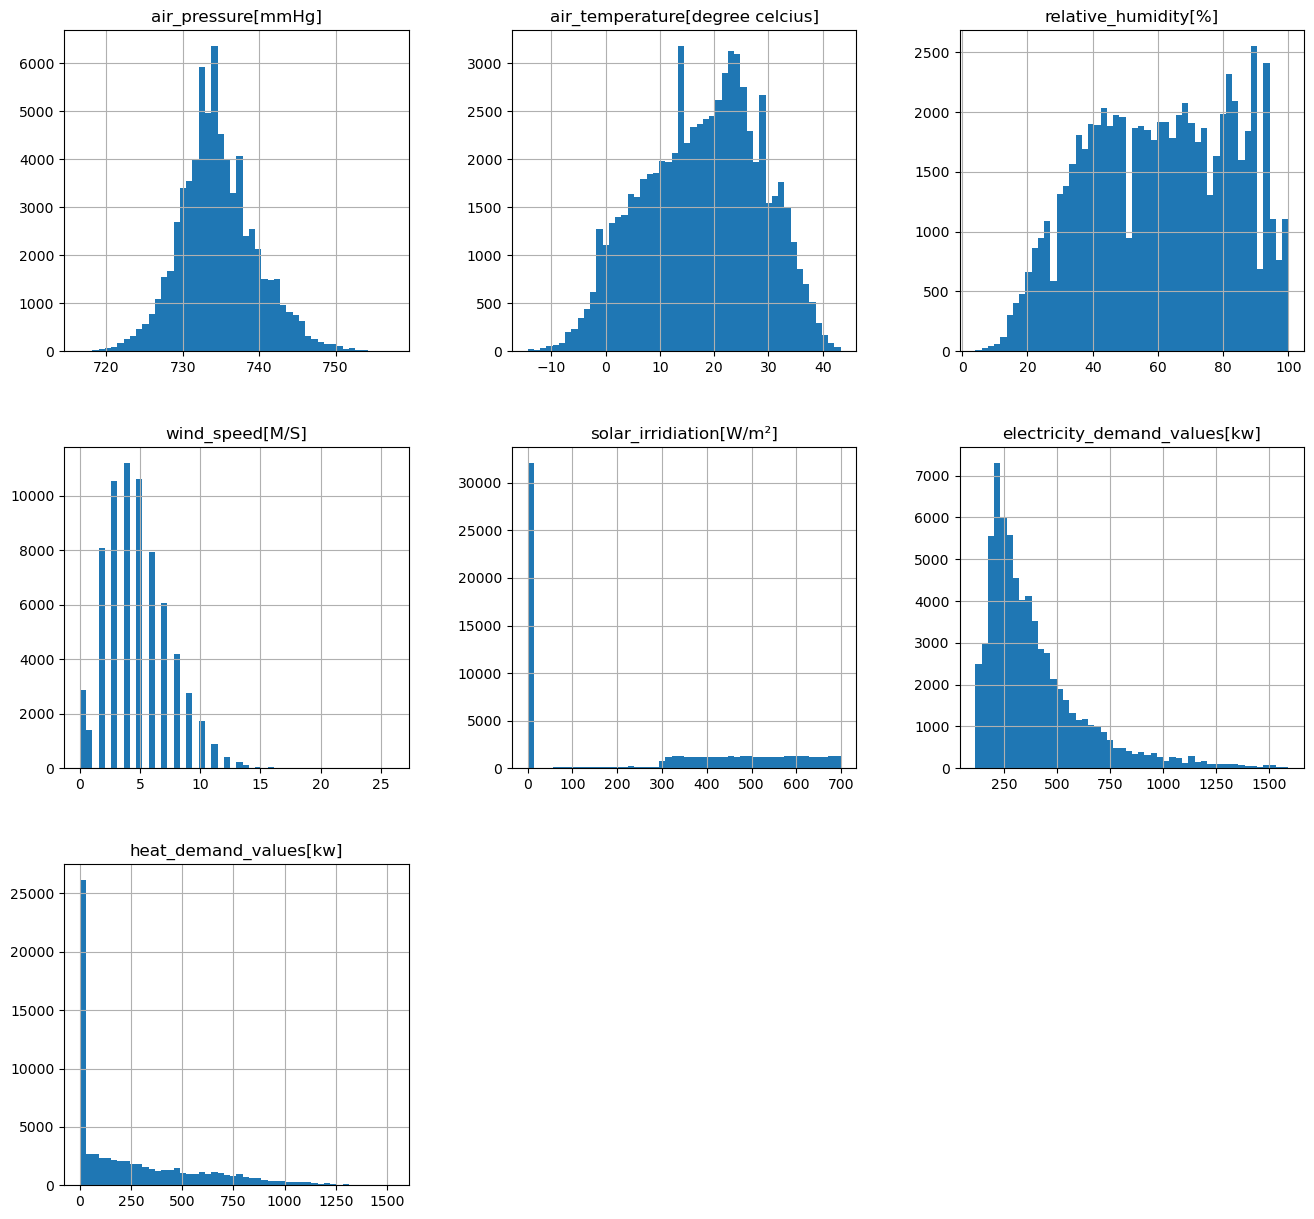

In [5]:
df.hist(bins=50, figsize=(16,15))
plt.show()

In [6]:
# Find NaN values in dataset to improve dataset quality.
df[df.isna().any(axis=1)]

,Time,air_pressure[mmHg],air_temperature[degree celcius],relative_humidity[%],wind_speed[M/S],solar_irridiation[W/m²],total_cloud_cover[from ten],electricity_demand_values[kw],heat_demand_values[kw]
130,2010-12-06 10:00:00,733.1,33.3,46.0,NaN,588,no clouds,333.817990,484.556708
375,2010-12-16 15:00:00,NaN,7.2,93.0,3.0,384,10/10.,375.382404,588.543953
376,2010-12-16 16:00:00,NaN,11.1,72.0,2.0,663,5/10.,451.820884,592.192796
613,2010-12-26 13:00:00,733.6,-2.2,96.0,7.0,600,NaN,381.252778,712.248685
1249,2011-01-22 01:00:00,736.8,20.6,93.0,9.0,0,NaN,290.154445,610.812280
...,...,...,...,...,...,...,...,...,...
68896,2018-10-10 16:00:00,728.6,19.0,94.0,4.0,460,NaN,244.096178,114.866493
69044,2018-10-16 20:00:00,NaN,5.0,70.0,5.0,0,no clouds,228.941001,81.630709
69046,2018-10-16 22:00:00,740.8,12.8,31.0,NaN,0,2/10–3/10.,258.874965,84.774228
69150,2018-10-21 06:00:00,743.2,10.0,26.0,NaN,0,7/10 – 8/10.,267.464345,10.436845


## Data Cleaning

In [7]:
df.isna().sum()

Time                                 0
air_pressure[mmHg]                 146
air_temperature[degree celcius]    177
relative_humidity[%]               177
wind_speed[M/S]                    955
solar_irridiation[W/m²]              0
total_cloud_cover[from ten]        243
electricity_demand_values[kw]        7
heat_demand_values[kw]               7
dtype: int64

In [8]:
print ("\nMissing values :  ", df.isnull().any())


Missing values :   Time                               False
air_pressure[mmHg]                  True
air_temperature[degree celcius]     True
relative_humidity[%]                True
wind_speed[M/S]                     True
solar_irridiation[W/m²]            False
total_cloud_cover[from ten]         True
electricity_demand_values[kw]       True
heat_demand_values[kw]              True
dtype: bool


**Note**: 
- NaN values for air_pressure, air_temperatur, relative_humidity are values which can be derived from previous and following values since radical inclines/declines in those features are not likely. 
- NaN values for wind speed and total cloud cover will be replaced with 0. 
- Also: cloud cover will be transformed to numeric values for better results when training the model.

In [9]:
# Interpolation of derivable values
df["air_pressure[mmHg]"].interpolate(inplace=True)
df["air_temperature[degree celcius]"].interpolate(inplace=True)
df["relative_humidity[%]"].interpolate(inplace=True)
df["heat_demand_values[kw]"].interpolate(inplace=True) # DEBUG
df["electricity_demand_values[kw]"].interpolate(inplace=True) # DEBUG

In [10]:
# Combine similar windspeed categories into one class
df["wind_speed_cat[M/S]"] = np.ceil(df["wind_speed[M/S]"])
df["wind_speed_cat[M/S]"].where(df["wind_speed[M/S]"] < 10, 10, inplace=True)

In [11]:
# Replace NaN for cloud_cover with 0
# Reshape total_cloud_cover to float
cloud_mapping = {
    'no clouds': 0,
    'Sky obscured by fog and/or other meteorological phenomena.': 0,
    'nan': 0,
    '2/10–3/10.': 0.25,
    '5/10.': 0.5,
    '10/10.': 1.0,
    '7/10 – 8/10.': 0.75,
    '4/10.': 0.4   
}
df["total_cloud_cover_numeric[from ten]"] = df["total_cloud_cover[from ten]"].apply(lambda x: cloud_mapping.get(x))
df["total_cloud_cover_numeric[from ten]"].fillna(value=0, inplace=True)

**Note**: wind_speed[M/S] & total_cloud_cover[from ten] were cleaned by adding further derived features.

In [12]:
df["DATETIME_NUMERIC"] = df["Time"].apply(pd.to_datetime)

## Checking for missing values

In [13]:
df_cleaned = df.copy()

In [14]:
df_cleaned.drop(columns=["wind_speed[M/S]", "total_cloud_cover[from ten]", "Time"], inplace=True)

In [15]:
# electricity_demand/heat_demand are not iterpolated.
df_cleaned.isnull().sum()

air_pressure[mmHg]                     0
air_temperature[degree celcius]        0
relative_humidity[%]                   0
solar_irridiation[W/m²]                0
electricity_demand_values[kw]          0
heat_demand_values[kw]                 0
wind_speed_cat[M/S]                    0
total_cloud_cover_numeric[from ten]    0
DATETIME_NUMERIC                       0
dtype: int64

In [16]:
print ("\nMissing values :  ", df_cleaned.isnull().any())


Missing values :   air_pressure[mmHg]                     False
air_temperature[degree celcius]        False
relative_humidity[%]                   False
solar_irridiation[W/m²]                False
electricity_demand_values[kw]          False
heat_demand_values[kw]                 False
wind_speed_cat[M/S]                    False
total_cloud_cover_numeric[from ten]    False
DATETIME_NUMERIC                       False
dtype: bool


## Checking for outliners

In [17]:
def visualize_box_plot(series: pd.Series):
    plt.rcParams.update({'figure.figsize': (10,10)})
    sns.boxplot(series)
    plt.show()

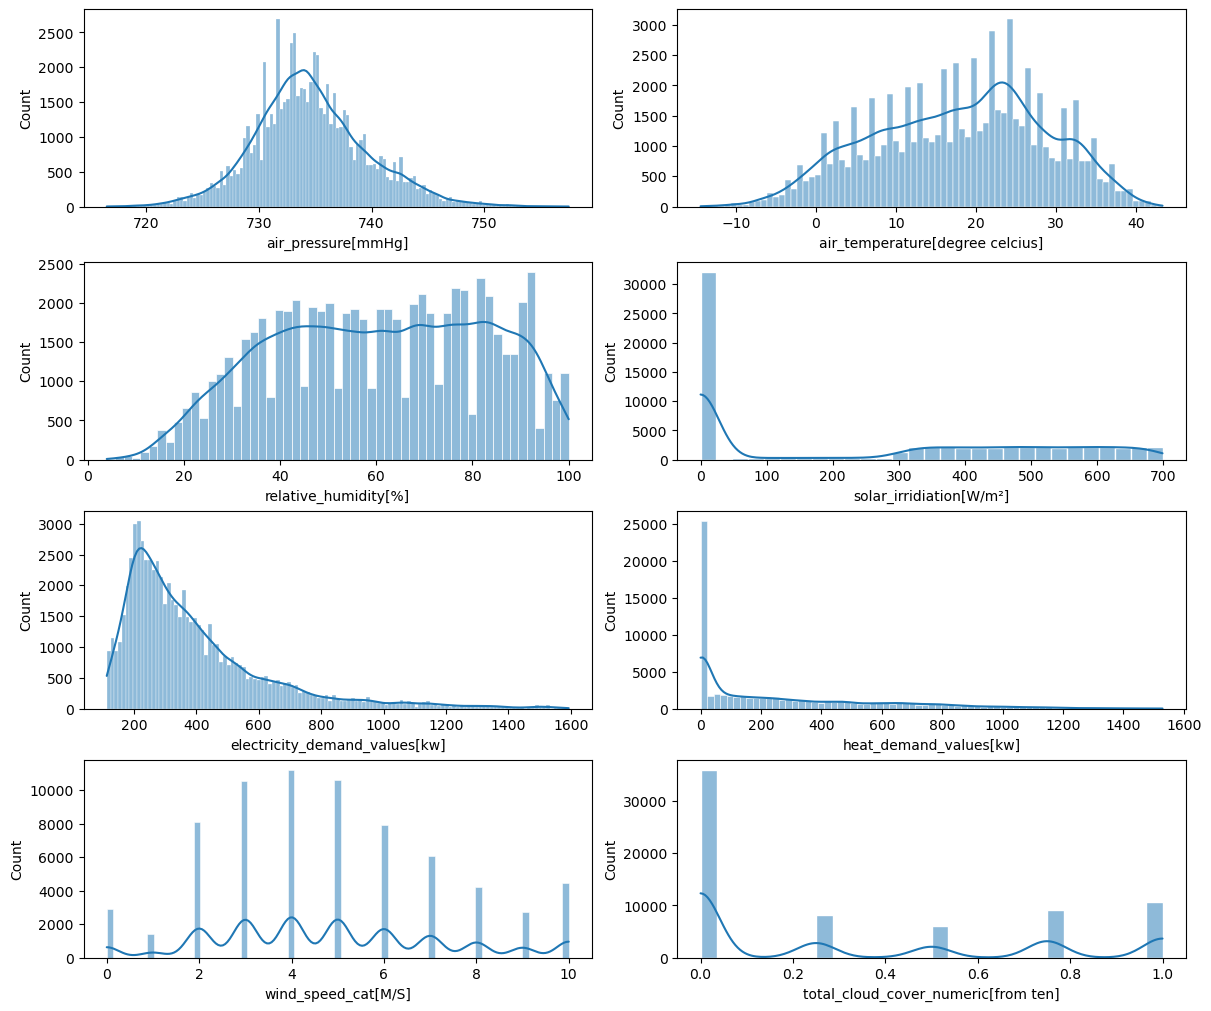

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,10), constrained_layout=True)

for axx, column in zip(axes.flatten(), df_cleaned.columns):
    sns.set_style("white")
    sns.histplot(x=df_cleaned[column], data=df_cleaned, ax=axx, kde=True)

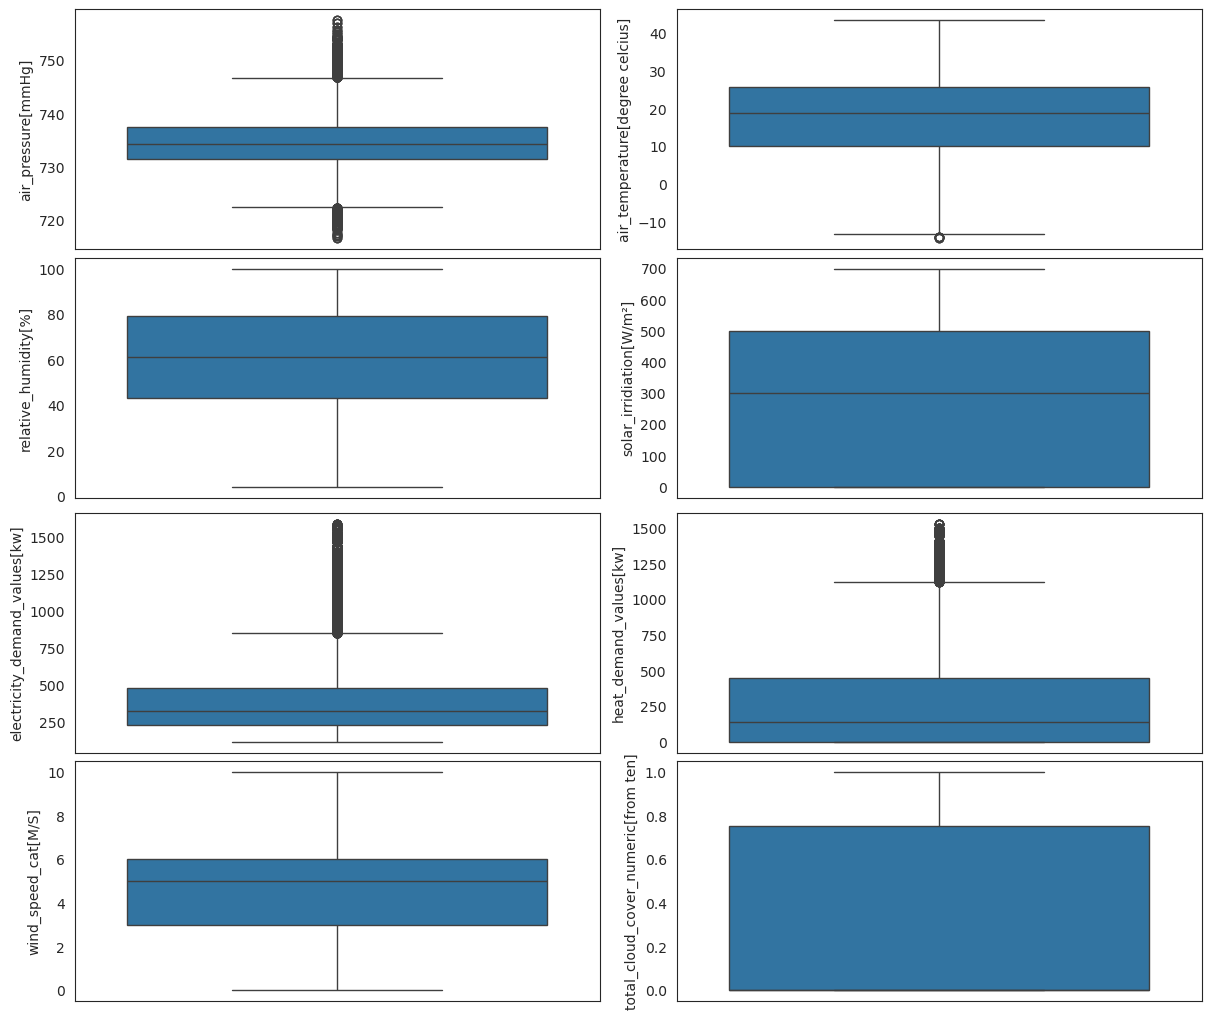

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,10), constrained_layout=True)
for axx, column in zip(axes.flatten(), df_cleaned.columns):
    sns.set_style("white")
    sns.boxplot(data=df_cleaned[column], ax=axx)

## Statistical Analysis

In [20]:
df_copy = df_cleaned.copy()
df_copy.set_index(keys="DATETIME_NUMERIC", inplace=True)
df_copy.index

DatetimeIndex(['2010-12-01 00:00:00', '2010-12-01 01:00:00',
               '2010-12-01 02:00:00', '2010-12-01 03:00:00',
               '2010-12-01 04:00:00', '2010-12-01 05:00:00',
               '2010-12-01 06:00:00', '2010-12-01 07:00:00',
               '2010-12-01 08:00:00', '2010-12-01 09:00:00',
               ...
               '2018-11-28 14:00:00', '2018-11-28 15:00:00',
               '2018-11-28 16:00:00', '2018-11-28 17:00:00',
               '2018-11-28 18:00:00', '2018-11-28 19:00:00',
               '2018-11-28 20:00:00', '2018-11-28 21:00:00',
               '2018-11-28 22:00:00', '2018-11-28 23:00:00'],
              dtype='datetime64[ns]', name='DATETIME_NUMERIC', length=70080, freq=None)

**Note**: For further statistical analysis of the timeseries a DateTimeIndex is recomended.

### Augmented Dickey-Fuller 
The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation. It is used to assess wether the timeseries data is stationary or not.

- H0: The data is **not** stationary.
- H1: The data is stationary (or trend-stationary).

In [21]:
def augmented_dickey_fuller_matrix(df: pd.DataFrame, columns: pd.DataFrame.columns, autolag="AIC"):
    result_cols = ["Name", "adfstat", "pvalue", "usedlag"]
    df_result = None
    for idx, col in enumerate(columns):
        print(f'Performing Augmented Dickey Fuller for {col}')
        adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(df[col], autolag=autolag)
        dct = dict(zip([*result_cols, *[f'crit_val_{x}' for x in critvalues.keys()]], [col, adfstat, pvalue, usedlag, *critvalues.values()]))
        if idx == 0:
            df_result = pd.DataFrame(dct, index=[idx])
            continue
        df_result = pd.concat([df_result,pd.DataFrame(dct, index=[idx])], ignore_index=True)
        
    return df_result
        

In [22]:
augmented_dickey_fuller_matrix(df_copy, columns=df_copy.columns)


Performing Augmented Dickey Fuller for air_pressure[mmHg]
Performing Augmented Dickey Fuller for air_temperature[degree celcius]
Performing Augmented Dickey Fuller for relative_humidity[%]
Performing Augmented Dickey Fuller for solar_irridiation[W/m²]
Performing Augmented Dickey Fuller for electricity_demand_values[kw]
Performing Augmented Dickey Fuller for heat_demand_values[kw]
Performing Augmented Dickey Fuller for wind_speed_cat[M/S]
Performing Augmented Dickey Fuller for total_cloud_cover_numeric[from ten]


,Name,adfstat,pvalue,usedlag,crit_val_1%,crit_val_5%,crit_val_10%
0,air_pressure[mmHg],-21.335919,0.000000e+00,62,-3.430443,-2.861581,-2.566792
1,air_temperature[degree celcius],-8.108459,1.244356e-12,61,-3.430443,-2.861581,-2.566792
2,relative_humidity[%],-21.853121,0.000000e+00,56,-3.430443,-2.861581,-2.566792
3,solar_irridiation[W/m²],-36.504272,0.000000e+00,62,-3.430443,-2.861581,-2.566792
4,electricity_demand_values[kw],-18.080651,2.587575e-30,62,-3.430443,-2.861581,-2.566792
5,heat_demand_values[kw],-7.792917,7.854580e-12,62,-3.430443,-2.861581,-2.566792
6,wind_speed_cat[M/S],-24.053629,0.000000e+00,59,-3.430443,-2.861581,-2.566792
7,total_cloud_cover_numeric[from ten],-29.109673,0.000000e+00,62,-3.430443,-2.861581,-2.566792


### Interpretation of the result

Since the p-values for all features are **less** than the significancel level (0.05) and **all** critical values are **greater** than the `ADF Statistic` the null hypothesis can be rejected. This implies that all features/timeseries are stationary, which is a key requirement for performing `VectorAutoregression`.

## Granger’s Causality Test

In [23]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests

In [24]:
maxlag = 12 # 12 Months

test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [25]:
df_copy.dropna(inplace=True)
grangers_caustaiton_matrix_result = grangers_causation_matrix(df_copy, variables=df_copy.columns)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70077, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=385426.6658, p=0.0000  , df_denom=70077, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70075, df_num=2
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=205715.4911, p=0.0000  , df_denom=70075, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70073, df_num=3
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=142768.4819, p=0.0000  , df_denom=70073, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F

ssr based F test:         F=419.7983, p=0.0000  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=5039.3779, p=0.0000  , df=12
likelihood ratio test: chi2=4866.4045, p=0.0000  , df=12
parameter F test:         F=419.7983, p=0.0000  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.9234  , p=0.0016  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=9.9238  , p=0.0016  , df=1
likelihood ratio test: chi2=9.9231  , p=0.0016  , df=1
parameter F test:         F=9.9234  , p=0.0016  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=193.2054, p=0.0000  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=386.4385, p=0.0000  , df=2
likelihood ratio test: chi2=385.3769, p=0.0000  , df=2
parameter F test:         F=193.2054, p=0.0000  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=556.9028, p=0.0000  , df_denom=70070, df_num=3
s

ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70069, df_num=5
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=5
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=5
parameter F test:         F=104643.8469, p=0.0000  , df_denom=70069, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70067, df_num=6
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=6
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=6
parameter F test:         F=87456.5501, p=0.0000  , df_denom=70067, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70065, df_num=7
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=7
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=7
parameter F test:         F=75903.2789, p=0.0000  , df_denom=70065, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70063, df_num=8


ssr based F test:         F=0.5682  , p=0.8412  , df_denom=70049, df_num=10
ssr based chi2 test:   chi2=5.6837  , p=0.8411  , df=10
likelihood ratio test: chi2=5.6835  , p=0.8411  , df=10
parameter F test:         F=0.5682  , p=0.8412  , df_denom=70049, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.8110  , p=0.6292  , df_denom=70046, df_num=11
ssr based chi2 test:   chi2=8.9241  , p=0.6289  , df=11
likelihood ratio test: chi2=8.9236  , p=0.6289  , df=11
parameter F test:         F=0.8110  , p=0.6292  , df_denom=70046, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.4447  , p=0.1374  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=17.3425 , p=0.1372  , df=12
likelihood ratio test: chi2=17.3404 , p=0.1372  , df=12
parameter F test:         F=1.4447  , p=0.1374  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2594  , p=0.6105  , df_denom=70076, df

ssr based F test:         F=1395.2358, p=0.0000  , df_denom=70070, df_num=3
ssr based chi2 test:   chi2=4186.1257, p=0.0000  , df=3
likelihood ratio test: chi2=4065.8606, p=0.0000  , df=3
parameter F test:         F=1395.2358, p=0.0000  , df_denom=70070, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1162.4260, p=0.0000  , df_denom=70067, df_num=4
ssr based chi2 test:   chi2=4650.3014, p=0.0000  , df=4
likelihood ratio test: chi2=4502.5061, p=0.0000  , df=4
parameter F test:         F=1162.4260, p=0.0000  , df_denom=70067, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1085.0902, p=0.0000  , df_denom=70064, df_num=5
ssr based chi2 test:   chi2=5426.3029, p=0.0000  , df=5
likelihood ratio test: chi2=5226.4609, p=0.0000  , df=5
parameter F test:         F=1085.0902, p=0.0000  , df_denom=70064, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=876.5970, p=0.0000  , df_denom=70061, df_n

ssr based F test:         F=1947.9364, p=0.0000  , df_denom=70061, df_num=6
ssr based chi2 test:   chi2=11689.7871, p=0.0000  , df=6
likelihood ratio test: chi2=10811.2002, p=0.0000  , df=6
parameter F test:         F=1947.9364, p=0.0000  , df_denom=70061, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1790.9250, p=0.0000  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=12539.1588, p=0.0000  , df=7
likelihood ratio test: chi2=11535.3693, p=0.0000  , df=7
parameter F test:         F=1790.9250, p=0.0000  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1662.3086, p=0.0000  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=13301.6960, p=0.0000  , df=8
likelihood ratio test: chi2=12179.1848, p=0.0000  , df=8
parameter F test:         F=1662.3086, p=0.0000  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1267.5854, p=0.0000  , df_denom=7005

ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70061, df_num=9
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=9
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=9
parameter F test:         F=15229.9240, p=0.0000  , df_denom=70061, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70059, df_num=10
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=10
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=10
parameter F test:         F=13706.9878, p=0.0000  , df_denom=70059, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70057, df_num=11
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=11
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=11
parameter F test:         F=12556.7231, p=0.0000  , df_denom=70057, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70055,

ssr based F test:         F=2.4067  , p=0.0041  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=28.8906 , p=0.0041  , df=12
likelihood ratio test: chi2=28.8847 , p=0.0041  , df=12
parameter F test:         F=2.4067  , p=0.0041  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8875  , p=0.3461  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=0.8876  , p=0.3461  , df=1
likelihood ratio test: chi2=0.8876  , p=0.3461  , df=1
parameter F test:         F=0.8875  , p=0.3461  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6687  , p=0.5124  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=1.3375  , p=0.5123  , df=2
likelihood ratio test: chi2=1.3375  , p=0.5123  , df=2
parameter F test:         F=0.6687  , p=0.5124  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0739  , p=0.1013  , df_denom=70070, df_num=3
ssr

ssr based F test:         F=1698.1416, p=0.0000  , df_denom=70067, df_num=4
ssr based chi2 test:   chi2=6793.4389, p=0.0000  , df=4
likelihood ratio test: chi2=6483.9933, p=0.0000  , df=4
parameter F test:         F=1698.1416, p=0.0000  , df_denom=70067, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1422.4076, p=0.0000  , df_denom=70064, df_num=5
ssr based chi2 test:   chi2=7113.1547, p=0.0000  , df=5
likelihood ratio test: chi2=6774.8448, p=0.0000  , df=5
parameter F test:         F=1422.4076, p=0.0000  , df_denom=70064, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1153.3287, p=0.0000  , df_denom=70061, df_num=6
ssr based chi2 test:   chi2=6921.2562, p=0.0000  , df=6
likelihood ratio test: chi2=6600.4092, p=0.0000  , df=6
parameter F test:         F=1153.3287, p=0.0000  , df_denom=70061, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=961.7518, p=0.0000  , df_denom=70058, df_n

ssr based F test:         F=0.3068  , p=0.9512  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=2.1482  , p=0.9512  , df=7
likelihood ratio test: chi2=2.1482  , p=0.9512  , df=7
parameter F test:         F=0.3068  , p=0.9512  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.3670  , p=0.9383  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=2.9369  , p=0.9383  , df=8
likelihood ratio test: chi2=2.9369  , p=0.9383  , df=8
parameter F test:         F=0.3670  , p=0.9383  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.3182  , p=0.9694  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=2.8649  , p=0.9694  , df=9
likelihood ratio test: chi2=2.8649  , p=0.9694  , df=9
parameter F test:         F=0.3182  , p=0.9694  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.2787  , p=0.9860  , df_denom=70049, df_num=10
ssr b

ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70057, df_num=11
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=11
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=11
parameter F test:         F=18753.2464, p=0.0000  , df_denom=70057, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70055, df_num=12
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=12
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=12
parameter F test:         F=25922.6444, p=0.0000  , df_denom=70055, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7064.0129, p=0.0000  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=7064.3154, p=0.0000  , df=1
likelihood ratio test: chi2=6730.5100, p=0.0000  , df=1
parameter F test:         F=7064.0129, p=0.0000  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=505.4370, p=0.0000  , df_denom=70073,

ssr based F test:         F=0.4061  , p=0.8044  , df_denom=70067, df_num=4
ssr based chi2 test:   chi2=1.6247  , p=0.8043  , df=4
likelihood ratio test: chi2=1.6247  , p=0.8043  , df=4
parameter F test:         F=0.4061  , p=0.8044  , df_denom=70067, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6445  , p=0.6657  , df_denom=70064, df_num=5
ssr based chi2 test:   chi2=3.2232  , p=0.6656  , df=5
likelihood ratio test: chi2=3.2231  , p=0.6656  , df=5
parameter F test:         F=0.6445  , p=0.6657  , df_denom=70064, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7653  , p=0.5971  , df_denom=70061, df_num=6
ssr based chi2 test:   chi2=4.5926  , p=0.5970  , df=6
likelihood ratio test: chi2=4.5924  , p=0.5970  , df=6
parameter F test:         F=0.7653  , p=0.5971  , df_denom=70061, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.7877  , p=0.5975  , df_denom=70058, df_num=7
ssr bas

ssr based F test:         F=0.9883  , p=0.4375  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=6.9194  , p=0.4373  , df=7
likelihood ratio test: chi2=6.9191  , p=0.4374  , df=7
parameter F test:         F=0.9883  , p=0.4375  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1036  , p=0.3570  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=8.8309  , p=0.3568  , df=8
likelihood ratio test: chi2=8.8303  , p=0.3568  , df=8
parameter F test:         F=1.1036  , p=0.3570  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9129  , p=0.5125  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=8.2187  , p=0.5123  , df=9
likelihood ratio test: chi2=8.2182  , p=0.5123  , df=9
parameter F test:         F=0.9129  , p=0.5125  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7770  , p=0.6513  , df_denom=70049, df_num=10
ssr b

likelihood ratio test: chi2=27.4546 , p=0.0039  , df=11
parameter F test:         F=2.4955  , p=0.0039  , df_denom=70046, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.2363  , p=0.0082  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=26.8458 , p=0.0081  , df=12
likelihood ratio test: chi2=26.8406 , p=0.0081  , df=12
parameter F test:         F=2.2363  , p=0.0082  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2965.7839, p=0.0000  , df_denom=70076, df_num=1
ssr based chi2 test:   chi2=2965.9109, p=0.0000  , df=1
likelihood ratio test: chi2=2904.8651, p=0.0000  , df=1
parameter F test:         F=2965.7839, p=0.0000  , df_denom=70076, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1599.1031, p=0.0000  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=3198.4344, p=0.0000  , df=2
likelihood ratio test: chi2=3127.5920, p=0.0000  , df=2
parameter F t

parameter F test:         F=194.6872, p=0.0000  , df_denom=70067, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=318.5942, p=0.0000  , df_denom=70064, df_num=5
ssr based chi2 test:   chi2=1593.2213, p=0.0000  , df=5
likelihood ratio test: chi2=1575.3795, p=0.0000  , df=5
parameter F test:         F=318.5942, p=0.0000  , df_denom=70064, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=248.9743, p=0.0000  , df_denom=70061, df_num=6
ssr based chi2 test:   chi2=1494.1229, p=0.0000  , df=6
likelihood ratio test: chi2=1478.4169, p=0.0000  , df=6
parameter F test:         F=248.9743, p=0.0000  , df_denom=70061, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=225.6645, p=0.0000  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=1579.9896, p=0.0000  , df=7
likelihood ratio test: chi2=1562.4403, p=0.0000  , df=7
parameter F test:         F=225.6645, p=0.0000  , df_denom=70058, df_num=7



ssr based F test:         F=0.7320  , p=0.6950  , df_denom=70049, df_num=10
ssr based chi2 test:   chi2=7.3218  , p=0.6948  , df=10
likelihood ratio test: chi2=7.3214  , p=0.6948  , df=10
parameter F test:         F=0.7320  , p=0.6950  , df_denom=70049, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.6713  , p=0.7671  , df_denom=70046, df_num=11
ssr based chi2 test:   chi2=7.3872  , p=0.7669  , df=11
likelihood ratio test: chi2=7.3868  , p=0.7670  , df=11
parameter F test:         F=0.6713  , p=0.7671  , df_denom=70046, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.6919  , p=0.7610  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=8.3061  , p=0.7608  , df=12
likelihood ratio test: chi2=8.3056  , p=0.7608  , df=12
parameter F test:         F=0.6919  , p=0.7610  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6235  , p=0.4297  , df_denom=70076, df

parameter F test:         F=0.4840  , p=0.7476  , df_denom=70067, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9430  , p=0.4516  , df_denom=70064, df_num=5
ssr based chi2 test:   chi2=4.7158  , p=0.4515  , df=5
likelihood ratio test: chi2=4.7156  , p=0.4516  , df=5
parameter F test:         F=0.9430  , p=0.4516  , df_denom=70064, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.8491  , p=0.5317  , df_denom=70061, df_num=6
ssr based chi2 test:   chi2=5.0958  , p=0.5316  , df=6
likelihood ratio test: chi2=5.0956  , p=0.5316  , df=6
parameter F test:         F=0.8491  , p=0.5317  , df_denom=70061, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.5707  , p=0.7804  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=3.9957  , p=0.7803  , df=7
likelihood ratio test: chi2=3.9956  , p=0.7803  , df=7
parameter F test:         F=0.5707  , p=0.7804  , df_denom=70058, df_num=7

Grange

ssr based F test:         F=167.5608, p=0.0000  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=1508.4563, p=0.0000  , df=9
likelihood ratio test: chi2=1492.4490, p=0.0000  , df=9
parameter F test:         F=167.5608, p=0.0000  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=140.9307, p=0.0000  , df_denom=70049, df_num=10
ssr based chi2 test:   chi2=1409.7296, p=0.0000  , df=10
likelihood ratio test: chi2=1395.7359, p=0.0000  , df=10
parameter F test:         F=140.9307, p=0.0000  , df_denom=70049, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=146.8672, p=0.0000  , df_denom=70046, df_num=11
ssr based chi2 test:   chi2=1616.0693, p=0.0000  , df=11
likelihood ratio test: chi2=1597.7145, p=0.0000  , df=11
parameter F test:         F=146.8672, p=0.0000  , df_denom=70046, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=165.1924, p=0.0000  , df_denom=70043,

ssr based F test:         F=1.0460  , p=0.3513  , df_denom=70073, df_num=2
ssr based chi2 test:   chi2=2.0922  , p=0.3513  , df=2
likelihood ratio test: chi2=2.0921  , p=0.3513  , df=2
parameter F test:         F=1.0460  , p=0.3513  , df_denom=70073, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5042  , p=0.2112  , df_denom=70070, df_num=3
ssr based chi2 test:   chi2=4.5130  , p=0.2111  , df=3
likelihood ratio test: chi2=4.5128  , p=0.2111  , df=3
parameter F test:         F=1.5042  , p=0.2112  , df_denom=70070, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1740  , p=0.3199  , df_denom=70067, df_num=4
ssr based chi2 test:   chi2=4.6968  , p=0.3198  , df=4
likelihood ratio test: chi2=4.6966  , p=0.3199  , df=4
parameter F test:         F=1.1740  , p=0.3199  , df_denom=70067, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9674  , p=0.4361  , df_denom=70064, df_num=5
ssr bas

ssr based F test:         F=289.0011, p=0.0000  , df_denom=70061, df_num=6
ssr based chi2 test:   chi2=1734.3285, p=0.0000  , df=6
likelihood ratio test: chi2=1713.2139, p=0.0000  , df=6
parameter F test:         F=289.0011, p=0.0000  , df_denom=70061, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=233.5751, p=0.0000  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=1635.3756, p=0.0000  , df=7
likelihood ratio test: chi2=1616.5840, p=0.0000  , df=7
parameter F test:         F=233.5751, p=0.0000  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=151.6460, p=0.0000  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=1213.4621, p=0.0000  , df=8
likelihood ratio test: chi2=1203.0749, p=0.0000  , df=8
parameter F test:         F=151.6460, p=0.0000  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=181.7434, p=0.0000  , df_denom=70052, df_num=9
s

ssr based F test:         F=0.7173  , p=0.7090  , df_denom=70049, df_num=10
ssr based chi2 test:   chi2=7.1754  , p=0.7088  , df=10
likelihood ratio test: chi2=7.1750  , p=0.7088  , df=10
parameter F test:         F=0.7173  , p=0.7090  , df_denom=70049, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.7032  , p=0.7368  , df_denom=70046, df_num=11
ssr based chi2 test:   chi2=7.7378  , p=0.7366  , df=11
likelihood ratio test: chi2=7.7373  , p=0.7366  , df=11
parameter F test:         F=0.7032  , p=0.7368  , df_denom=70046, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.9593  , p=0.4857  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=11.5155 , p=0.4853  , df=12
likelihood ratio test: chi2=11.5146 , p=0.4854  , df=12
parameter F test:         F=0.9593  , p=0.4857  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0078  , p=0.9295  , df_denom=70076, df

parameter F test:         F=4261.0051, p=0.0000  , df_denom=70071, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70069, df_num=5
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=5
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=5
parameter F test:         F=3680.6036, p=0.0000  , df_denom=70069, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=70067, df_num=6
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=6
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=6
parameter F test:         F=3099.9026, p=0.0000  , df_denom=70067, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70065, df_num=7
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=7
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=7
parameter F test:         F=2690.5588, p=0.0000  , df_denom=70065, df_num=7

Gr

ssr based F test:         F=155.2308, p=0.0000  , df_denom=70049, df_num=10
ssr based chi2 test:   chi2=1552.7729, p=0.0000  , df=10
likelihood ratio test: chi2=1535.8179, p=0.0000  , df=10
parameter F test:         F=155.2308, p=0.0000  , df_denom=70049, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=139.6821, p=0.0000  , df_denom=70046, df_num=11
ssr based chi2 test:   chi2=1537.0078, p=0.0000  , df=11
likelihood ratio test: chi2=1520.3928, p=0.0000  , df=11
parameter F test:         F=139.6821, p=0.0000  , df_denom=70046, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=132.0655, p=0.0000  , df_denom=70043, df_num=12
ssr based chi2 test:   chi2=1585.3512, p=0.0000  , df=12
likelihood ratio test: chi2=1567.6822, p=0.0000  , df=12
parameter F test:         F=132.0655, p=0.0000  , df_denom=70043, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2279.4436, p=0.0000  , df_denom=70

ssr based F test:         F=0.3099  , p=0.9073  , df_denom=70064, df_num=5
ssr based chi2 test:   chi2=1.5500  , p=0.9072  , df=5
likelihood ratio test: chi2=1.5500  , p=0.9072  , df=5
parameter F test:         F=0.3099  , p=0.9073  , df_denom=70064, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.4536  , p=0.8429  , df_denom=70061, df_num=6
ssr based chi2 test:   chi2=2.7222  , p=0.8428  , df=6
likelihood ratio test: chi2=2.7222  , p=0.8428  , df=6
parameter F test:         F=0.4536  , p=0.8429  , df_denom=70061, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.4465  , p=0.8731  , df_denom=70058, df_num=7
ssr based chi2 test:   chi2=3.1262  , p=0.8731  , df=7
likelihood ratio test: chi2=3.1261  , p=0.8731  , df=7
parameter F test:         F=0.4465  , p=0.8731  , df_denom=70058, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7835  , p=0.6173  , df_denom=70055, df_num=8
ssr bas

ssr based F test:         F=1.1308  , p=0.3384  , df_denom=70055, df_num=8
ssr based chi2 test:   chi2=9.0486  , p=0.3382  , df=8
likelihood ratio test: chi2=9.0480  , p=0.3383  , df=8
parameter F test:         F=1.1308  , p=0.3384  , df_denom=70055, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9944  , p=0.0358  , df_denom=70052, df_num=9
ssr based chi2 test:   chi2=17.9545 , p=0.0357  , df=9
likelihood ratio test: chi2=17.9522 , p=0.0357  , df=9
parameter F test:         F=1.9944  , p=0.0358  , df_denom=70052, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3272  , p=0.0098  , df_denom=70049, df_num=10
ssr based chi2 test:   chi2=23.2791 , p=0.0098  , df=10
likelihood ratio test: chi2=23.2752 , p=0.0098  , df=10
parameter F test:         F=2.3272  , p=0.0098  , df_denom=70049, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=2.0520  , p=0.0203  , df_denom=70046, df_num=11


ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70057, df_num=11
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=11
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=11
parameter F test:         F=2843.9794, p=0.0000  , df_denom=70057, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=70055, df_num=12
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=12
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=12
parameter F test:         F=2634.2723, p=0.0000  , df_denom=70055, df_num=12


In [26]:
grangers_caustaiton_matrix_result

,air_pressure[mmHg]_x,air_temperature[degree celcius]_x,relative_humidity[%]_x,solar_irridiation[W/m²]_x,electricity_demand_values[kw]_x,heat_demand_values[kw]_x,wind_speed_cat[M/S]_x,total_cloud_cover_numeric[from ten]_x
air_pressure[mmHg]_y,1.0000,0.0000,0.0000,0.6661,0.0193,0.0165,0.0000,0.0000
air_temperature[degree celcius]_y,0.0000,1.0000,0.0000,0.7285,0.0045,0.0663,0.0000,0.0000
relative_humidity[%]_y,0.0000,0.0000,1.0000,0.5018,0.0000,0.1706,0.0000,0.0000
solar_irridiation[W/m²]_y,0.0787,0.1372,0.0480,1.0000,0.0000,0.0000,0.2406,0.1809
electricity_demand_values[kw]_y,0.0917,0.4176,0.0001,0.0000,1.0000,0.0000,0.0027,0.1825
heat_demand_values[kw]_y,0.0040,0.0034,0.0061,0.0000,0.0000,1.0000,0.1958,0.0098
wind_speed_cat[M/S]_y,0.0000,0.0000,0.0000,0.5844,0.0015,0.0823,1.0000,0.0000
total_cloud_cover_numeric[from ten]_y,0.0000,0.0000,0.0000,0.5692,0.3848,0.0977,0.0000,1.0000


In [27]:
grangers_caustaiton_matrix_result.loc[["electricity_demand_values[kw]_y", "heat_demand_values[kw]_y"]]

,air_pressure[mmHg]_x,air_temperature[degree celcius]_x,relative_humidity[%]_x,solar_irridiation[W/m²]_x,electricity_demand_values[kw]_x,heat_demand_values[kw]_x,wind_speed_cat[M/S]_x,total_cloud_cover_numeric[from ten]_x
electricity_demand_values[kw]_y,0.0917,0.4176,0.0001,0.0,1.0,0.0,0.0027,0.1825
heat_demand_values[kw]_y,0.0040,0.0034,0.0061,0.0,0.0,1.0,0.1958,0.0098


### Interpretation of the result

Let's take the value 0.0031 (row 2, column 1) it refers to the p-value of `air_pressure[mmHg]_x` causing `heat_demand_values[kw]_y`. How do we interpret the p-values?

If a given p-value is less than the significance level (0.05), then, the corresponding X series(column) causes the Y (row). With other words, if p < alpha (significance level) the null hypothesis can be rejectect and the conclusion that X causes Y can be done. 

How can we use this result?

H0: X does not granger cause Y\
H1: X does granger cause Y, **if p-value > 0.05 then H0 is accepted**, i.e. X does not granger cause Y.

What does this mean for the dataset?
If we take a look at the `electricity_demand_values[kw]_y` and `heat_demand_values[kw]_y` we can see that some of the p-values for some `Xs` are **> 0.05**. This means that the null hypothesis *X does not cause Y* can be accepted. For the furhter predictions we should split the dataset into two. One for predicting `electricity_demand_values[kw]` and one for predicting `heat_demand_values[kw]`. 

In [28]:
df_heat_raw = df_cleaned.copy()
df_elec_raw = df_cleaned.copy()

In [29]:
# Drop columns in both dataframes where H0 is accepted.
df_heat = df_heat_raw.drop(columns=["electricity_demand_values[kw]","wind_speed_cat[M/S]"])
df_elec = df_elec_raw.drop(columns=[ "heat_demand_values[kw]", "air_pressure[mmHg]", "air_temperature[degree celcius]", "total_cloud_cover_numeric[from ten]"])
# df_heat = df_heat_raw.drop(columns=["electricity_demand_values[kw]"])
# df_elec = df_elec_raw.drop(columns=["heat_demand_values[kw]"])

In [30]:
df_heat.info()
df_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   air_pressure[mmHg]                   70080 non-null  float64       
 1   air_temperature[degree celcius]      70080 non-null  float64       
 2   relative_humidity[%]                 70080 non-null  float64       
 3   solar_irridiation[W/m²]              70080 non-null  int64         
 4   heat_demand_values[kw]               70080 non-null  float64       
 5   total_cloud_cover_numeric[from ten]  70080 non-null  float64       
 6   DATETIME_NUMERIC                     70080 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 3.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 

In [31]:
# change DATETIME_NUMERIC to be index
df_heat.set_index(keys="DATETIME_NUMERIC", inplace=True)
df_elec.set_index(keys="DATETIME_NUMERIC", inplace=True)

## Cointegration Test

In [32]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [33]:
cointegration_test(df_elec)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
relative_humidity[%] ::  22050.49  > 40.1749   =>   True
solar_irridiation[W/m²] ::  11161.06  > 24.2761   =>   True
electricity_demand_values[kw] ::  4657.74   > 12.3212   =>   True
wind_speed_cat[M/S] ::  126.62    > 4.1296    =>   True


In [34]:
cointegration_test(df_heat)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
air_pressure[mmHg] ::  22153.33  > 83.9383   =>   True
air_temperature[degree celcius] ::  11864.81  > 60.0627   =>   True
relative_humidity[%] ::  5133.39   > 40.1749   =>   True
solar_irridiation[W/m²] ::  1397.69   > 24.2761   =>   True
heat_demand_values[kw] ::  592.93    > 12.3212   =>   True
total_cloud_cover_numeric[from ten] ::  0.06      > 4.1296    =>   False


### Split the data into training and tesing data

In [35]:
# Check size of timeseries
print(f"df_elec: {df_elec.shape}")
print(f"df_heat: {df_heat.shape}")


df_elec: (70080, 4)
df_heat: (70080, 6)


**Note**: The data will be split into 3 sets:

- [X] Training Data (70%)
- [X] Validation Data (20%)
- [X] Test Data (10%)

In [36]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)

for i, (train_index, test_index) in enumerate(tscv.split(X=df_elec)):
    print(train_index.shape)
    print(test_index.shape)

(17520,)
(17520,)
(35040,)
(17520,)
(52560,)
(17520,)


In [37]:
import math

def test_train_validate_split(df: pd.DataFrame, percentages=(0.70,0.10,0.20)):
    return np.split(df, [int(percentages[0] * len(df)), int((percentages[0] + percentages[1]) * len(df))])

In [38]:
df_heat_train, df_heat_validate, df_heat_test = test_train_validate_split(df_heat)
df_elec_train, df_elec_validate, df_elec_test = test_train_validate_split(df_elec)

print(f"df_heat_train.shape: {df_heat_train.shape}")
print(f"df_heat_validate.shape: {df_heat_validate.shape}")
print(f"df_heat_test.shape: {df_heat_test.shape}")

print(f"df_elec_train.shape: {df_elec_train.shape}")
print(f"df_elec_validate.shape: {df_elec_validate.shape}")
print(f"df_elec_test.shape: {df_elec_test.shape}")


df_heat_train.shape: (49056, 6)
df_heat_validate.shape: (7007, 6)
df_heat_test.shape: (14017, 6)
df_elec_train.shape: (49056, 4)
df_elec_validate.shape: (7007, 4)
df_elec_test.shape: (14017, 4)


/home/ivan/anaconda3/envs/hatespeech-detection-NLP/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [39]:
import pickle

with open("./data/heat_data.pkl", "wb") as f:
    df_heat_combined = {
        "df_heat_train": df_heat_train,
        "df_heat_test": df_heat_test,
        "df_heat_validate": df_heat_validate
    }
    pickle.dump(df_heat_combined, f)

with open("./data/elec_data.pkl", "wb") as f:
    df_elec_combined = {
        "df_elec_train": df_elec_train,
        "df_elec_test": df_elec_test,
        "df_elec_validate": df_elec_validate
    }
    pickle.dump(df_elec_combined, f)


### Sanity Checks

In [40]:
import pickle
with open("./data/heat_data.pkl", "rb") as f:
    loaded_heat_data = pickle.load(f)
    
with open("./data/elec_data.pkl", "rb") as f:
    loaded_elec_data = pickle.load(f)

In [41]:
assert loaded_heat_data["df_heat_train"].equals(df_heat_train)
assert loaded_heat_data["df_heat_test"].equals(df_heat_test)
assert loaded_heat_data["df_heat_validate"].equals(df_heat_validate)

assert loaded_elec_data["df_elec_train"].equals(df_elec_train)
assert loaded_elec_data["df_elec_test"].equals(df_elec_test)
assert loaded_elec_data["df_elec_validate"].equals(df_elec_validate)

In [42]:
loaded_elec_data["df_elec_validate"].shape

(7007, 4)